In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Creating the matrix for the irt regression

In [2]:
dt=pd.read_csv('data.csv')

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import pandas as pd



estimators = [
    ('onehot', OneHotEncoder()),
    ('lr', LogisticRegression())
]
pipe = Pipeline(estimators)

# Just check the encoded variables
ohe = OneHotEncoder()
print(ohe.fit_transform(dt[['user', 'skill']]).toarray())

# IRT
pipe.fit(dt[['user', 'skill']], dt['correct'])
print(pipe.predict_proba(dt[['user', 'skill']]))


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.3920324  0.6079676 ]
 [0.3920324  0.6079676 ]
 [0.3920324  0.6079676 ]
 ...
 [0.22796977 0.77203023]
 [0.22796977 0.77203023]
 [0.22796977 0.77203023]]


/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [3]:
qaq=dt.groupby(['user','skill']).max(['win','fail'])

when the ratio (nb of wins +1)/(nb of fails +1) is greater than one we consider the user has succeded the skill

In [4]:
wa=((qaq.wins+1)/(qaq.fails+1))>1

In [5]:
bad_try=wa[wa==False].index
good_try=wa[wa==True].index

In [5]:
users=dt.user.unique()
ki=['user_'+str(i) for i in users]
wa=['skill_'+str(j) for j in dt.skill.unique()]

In [7]:
mat=pd.DataFrame(index=np.r_[good_try.values,bad_try.values],columns=np.r_[ki,wa])

In [8]:
mat[:]=0

In [9]:
mat['y']=0

In [10]:
for i,j in good_try.values:
    mat.loc[[(i,j)],['user_'+str(i),'skill_'+str(j),'y']]=1

In [11]:
for i,j in bad_try.values:
    mat.loc[[(i,j)],['user_'+str(i),'skill_'+str(j)]]=1

mat

In [12]:
mat_1=mat.drop('y',1)
mat_1
y=mat.y


/var/folders/rh/v2m3z36j1j71mqlvn91zps5c0000gn/T/ipykernel_39321/1110058849.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  mat_1=mat.drop('y',1)


In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
model=LogisticRegression(fit_intercept=False)


In [15]:
model.fit(mat_1.values,y)

LogisticRegression(fit_intercept=False)

cofs is the linear coefficient of the regression

In [6]:
cofs=pipe[1].coef_


the last 112 coefficients represent the 'difficulty' for each skill

In [1]:
diffik=pd.Series(index=np.sort(dt.skill.unique()),data=cofs.reshape(-1,)[-112:])

NameError: name 'pd' is not defined

we're going to change the name of the skill with regard to its difficulty by rank in the real dataframe

In [8]:

scv=diffik.sort_values().index.values

In [9]:
po=[]
for j in dt.skill.values:
    po.append((np.where(scv==j)[0]+1)[0])

In [10]:
dt.skill=po


the first coefficients represent the theta of each user

In [11]:
theta=pd.Series(index=ki,data=cofs.reshape(-1,)[:-112])

<Axes: >

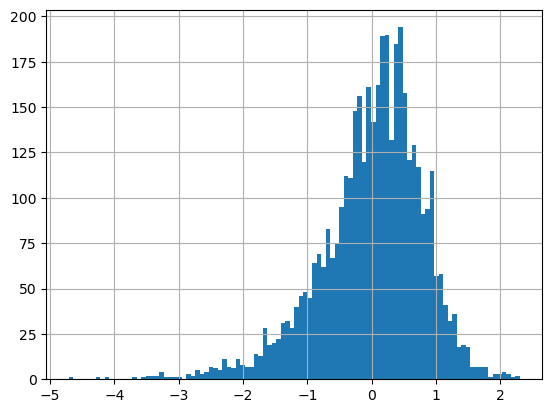

In [15]:
theta.hist(bins=100)

In [12]:
diffik=pd.Series(data=diffik.sort_values().values)

fiffik will represent the reward vector associated to each skill

In [13]:
fiffik=diffik-diffik.min()

4.33158225924638

In [18]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [14]:
def update_theta(theta,action,K):
    probs=sigmoid((theta-action))
    haz=np.random.binomial(1,p=probs)
    return theta+K*(haz-probs)

In [15]:
import decimal

we want to discretize to the nearest odd decimal
    

In [16]:
wa={}
for i in np.arange(-10.8,10.1,.2):
    wa[np.around(i,decimals=1)]=np.around(i,decimals=1)
for j in np.arange(-10.9,10,0.2):
    wa[np.around(j,decimals=1)]=np.around(j-0.1,decimals=1)

 we're creating a dataset for each user to map the evolution of its theta after being presented the skills in the same order of the dataset.
here dic_panda is the dictionnary of dataframe where each user is starting from a theta of 0 (main hypothesis).
We're also sampling from the bernouilli Law  associated to the skill and the prior theta for the new theta. \\
\\
Dic_panda creates stochastic dataframes!
fake_dic_panda is the same than dic_panda but with discretized theta.
fake_dic_panda_real is deterministic because we use the realizations of the real data set which creates biases because the original theta of the user is not necessarily equal to 0. 
fake_dic_panda_theta is like dic_panda but we start from the theta found from the irt regression.







In [19]:
dic_panda={}
for j in dt.user.unique():
    m=dt[dt.user==j]
    dic_panda['user_'+str(j)]=pd.DataFrame(index=np.arange(len(m)))
    dic_panda['user_'+str(j)]['theta_'+str(j)]=0
    dic_panda['user_'+str(j)]['action_'+str(j)]=m.skill.values
    l=[0]
    r=[]
    for i in dic_panda['user_'+str(j)]['action_'+str(j)]:
        l.append(update_theta(l[-1],diffik.iloc[i-1],1))
        r.append(((l[-1]-l[-2])>0)*fiffik.iloc[i-1])
    dic_panda['user_'+str(j)]['theta_'+str(j)]=l[:-1]
    dic_panda['user_'+str(j)]['reward_'+str(j)]=r
    dic_panda['user_'+str(j)]['new_theta_'+str(j)]=l[1:]

In [20]:

def upda_thet(theta,action,K,out):
    probs=sigmoid(K*(theta-action))
    
    return theta+K*(out-probs)

In [21]:
fake_dic_panda={}
for j in dt.user.unique():
    m=dt[dt.user==j]
    fake_dic_panda['user_'+str(j)]=pd.DataFrame(index=np.arange(len(m)))
    fake_dic_panda['user_'+str(j)]['theta_'+str(j)]=0
    fake_dic_panda['user_'+str(j)]['action_'+str(j)]=m.skill.values
    l=[0]
    r=[]
    for i in fake_dic_panda['user_'+str(j)]['action_'+str(j)]:
        l.append(wa[np.around(update_theta(l[-1],diffik.iloc[i-1],0.4),decimals=1)])
        r.append(((l[-1]-l[-2])>0)*fiffik.iloc[i-1])
    fake_dic_panda['user_'+str(j)]['theta_'+str(j)]=l[:-1]
    fake_dic_panda['user_'+str(j)]['reward_'+str(j)]=r
    fake_dic_panda['user_'+str(j)]['new_theta_'+str(j)]=l[1:]

In [22]:
fake_dic_panda_real={}
for j in dt.user.unique():
    m=dt[dt.user==j]
    fake_dic_panda_real['user_'+str(j)]=pd.DataFrame(index=np.arange(len(m)))
    fake_dic_panda_real['user_'+str(j)]['theta_'+str(j)]=0
    fake_dic_panda_real['user_'+str(j)]['action_'+str(j)]=m.skill.values
    l=[0]
    r=[]
    for i in range(len(m)):
        l.append(wa[np.around(upda_thet(l[-1],diffik.iloc[m.skill.iloc[i]-1],0.4,m.correct.iloc[i]),decimals=1)])
        r.append(((l[-1]-l[-2])>0)*fiffik.iloc[m.skill.iloc[i]-1])
    fake_dic_panda_real['user_'+str(j)]['theta_'+str(j)]=l[:-1]
    fake_dic_panda_real['user_'+str(j)]['reward_'+str(j)]=r
    fake_dic_panda_real['user_'+str(j)]['new_theta_'+str(j)]=l[1:]

In [63]:
fake_dic_panda_theta={}
for j in dt.user.unique():
    m=dt[dt.user==j]
    fake_dic_panda_theta['user_'+str(j)]=pd.DataFrame(index=np.arange(len(m)))
    fake_dic_panda_theta['user_'+str(j)]['theta_'+str(j)]=0
    fake_dic_panda_theta['user_'+str(j)]['action_'+str(j)]=m.skill.values
    l=[np.around(theta.loc['user_'+str(j)])]
    r=[]
    for i in fake_dic_panda_theta['user_'+str(j)]['action_'+str(j)]:
        l.append(wa[np.around(update_theta(l[-1],diffik.iloc[i-1],1),decimals=1)])
        r.append(((l[-1]-l[-2])>0)*fiffik.iloc[i-1])
    fake_dic_panda_theta['user_'+str(j)]['theta_'+str(j)]=l[:-1]
    fake_dic_panda_theta['user_'+str(j)]['reward_'+str(j)]=r
    fake_dic_panda_theta['user_'+str(j)]['new_theta_'+str(j)]=l[1:]

In [23]:


data_buf=np.concatenate([fake_dic_panda['user_'+str(j)].values for j in dt.user.unique()],axis=0)

In [24]:
data_buf_real=np.concatenate([fake_dic_panda_real['user_'+str(j)].values for j in dt.user.unique()],axis=0)

after concatenating all the dataframe we have a dataset usable for bandit algorithms that we can split into train and test set

In [25]:
dbf=pd.DataFrame(columns=['theta','action','reward','new_theta'],data=data_buf)
dbf_real=pd.DataFrame(columns=['theta','action','reward','new_theta'],data=data_buf_real)

In [26]:
bandit_dbf=dbf.drop('new_theta',1)

/var/folders/rh/v2m3z36j1j71mqlvn91zps5c0000gn/T/ipykernel_77260/475944543.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  bandit_dbf=dbf.drop('new_theta',1)


In [27]:
bandit_dbf_real=dbf_real.drop('new_theta',1)

/var/folders/rh/v2m3z36j1j71mqlvn91zps5c0000gn/T/ipykernel_77260/3507911797.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  bandit_dbf_real=dbf_real.drop('new_theta',1)


In [28]:
from sklearn.model_selection import train_test_split

In [29]:
bandit_dbf_real_train,bandit_dbf_real_test=train_test_split(bandit_dbf_real,test_size=0.33)

In [30]:
bandit_dbf_train,bandit_dbf_test=train_test_split(bandit_dbf,test_size=0.33)

In [31]:
import seaborn as sns

empire_proba reflects the behavior policy of the dataset even though its highly biased due to biased theta

In [32]:
empire_proba=pd.DataFrame(index=dbf.theta.sort_values().unique(),columns=np.arange(1,113))
empire_proba_real=pd.DataFrame(index=dbf_real.theta.sort_values().unique(),columns=np.arange(1,113))

In [33]:
empire_proba_real_train=pd.DataFrame(index=bandit_dbf_real_train.theta.sort_values().unique(),columns=np.arange(1,113))

In [34]:
for j in bandit_dbf_real_train.theta.sort_values().unique():
    empire_proba_real_train.loc[j]=(np.bincount(bandit_dbf_real_train[bandit_dbf_real_train.theta==j].action,minlength=113)/len(bandit_dbf_real_train[bandit_dbf_real_train.theta==j].action))[1:]

In [35]:
for j in dbf.theta.sort_values().unique():
    empire_proba.loc[j]=(np.bincount(dbf[dbf.theta==j].action,minlength=113)/len(dbf[dbf.theta==j].action))[1:]
for j in dbf_real.theta.sort_values().unique():
    empire_proba_real.loc[j]=(np.bincount(dbf_real[dbf_real.theta==j].action,minlength=113)/len(dbf_real[dbf_real.theta==j].action))[1:]    

,1,2,3,4,5,6,7,8,9,10,...,103,104,105,106,107,108,109,110,111,112
-6.8,0.0,0.069767,0.0,0.0,0.0,0.0,0.046512,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-6.6,0.0,0.111111,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-6.4,0.0,0.009479,0.0,0.0,0.0,0.601896,0.033175,0.014218,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.023697,0.0,0.0,0.0
-6.2,0.0,0.00468,0.0,0.0,0.0,0.042122,0.017161,0.00468,0.00312,0.280811,...,0.0,0.0,0.026521,0.0,0.0,0.0,0.109204,0.0,0.0,0.00156
-6.0,0.001818,0.003636,0.0,0.0,0.001818,0.070909,0.027273,0.003636,0.001818,0.089091,...,0.001818,0.0,0.0,0.0,0.0,0.0,0.021818,0.0,0.0,0.029091
-5.8,0.002222,0.008889,0.0,0.0,0.006667,0.068889,0.015556,0.008889,0.002222,0.151111,...,0.0,0.0,0.071111,0.0,0.011111,0.0,0.033333,0.0,0.0,0.0
-5.6,0.002179,0.004357,0.0,0.0,0.004357,0.04793,0.015251,0.008715,0.004357,0.115468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.087146,0.0,0.0,0.004357
-5.4,0.001988,0.007952,0.0,0.0,0.001988,0.031809,0.013917,0.005964,0.001988,0.099404,...,0.0,0.0,0.069583,0.0,0.001988,0.0,0.04175,0.0,0.0,0.0
-5.2,0.001441,0.002882,0.0,0.0,0.001441,0.023055,0.014409,0.010086,0.0,0.096542,...,0.0,0.001441,0.012968,0.0,0.001441,0.0,0.010086,0.0,0.0,0.002882
-5.0,0.003989,0.005319,0.0,0.0,0.00133,0.022606,0.014628,0.006649,0.00266,0.121011,...,0.0,0.0,0.013298,0.0,0.00133,0.0,0.039894,0.0,0.0,0.0


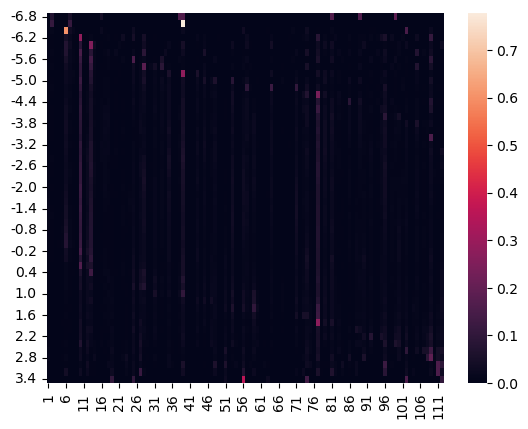

In [36]:
sns.heatmap(empire_proba_real.astype(float))
empire_proba_real

expected_reward is matrix with the expectation of the reward for each state-action pair.


In [37]:
expected_reward=pd.DataFrame(index=dbf.theta.sort_values().unique(),columns=np.arange(1,113))

In [38]:
expected_reward_real=pd.DataFrame(index=dbf_real.theta.sort_values().unique(),columns=np.arange(1,113))

In [39]:
expected_reward_real

,1,2,3,4,5,6,7,8,9,10,...,103,104,105,106,107,108,109,110,111,112
-6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
for j in expected_reward.index:
    for a in range(1,113):
        
    
        expected_reward.loc[j,a]=sigmoid(j-diffik.iloc[a-1])*fiffik.iloc[a-1]

In [41]:
for j in expected_reward_real.index:
    for a in range(1,113):
        
    
        expected_reward_real.loc[j,a]=sigmoid(j-diffik.iloc[a-1])*fiffik.iloc[a-1]

<Axes: >

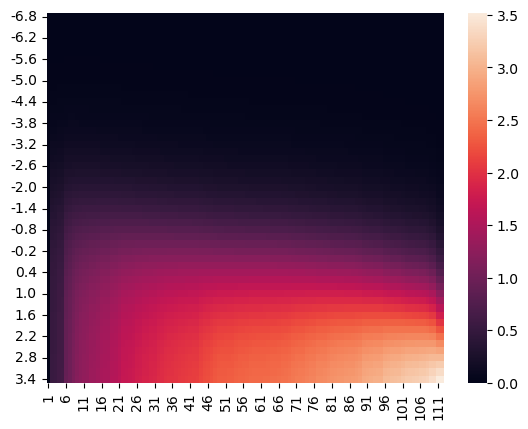

In [42]:
sns.heatmap(expected_reward_real.astype(float))

IndexError: single positional indexer is out-of-bounds

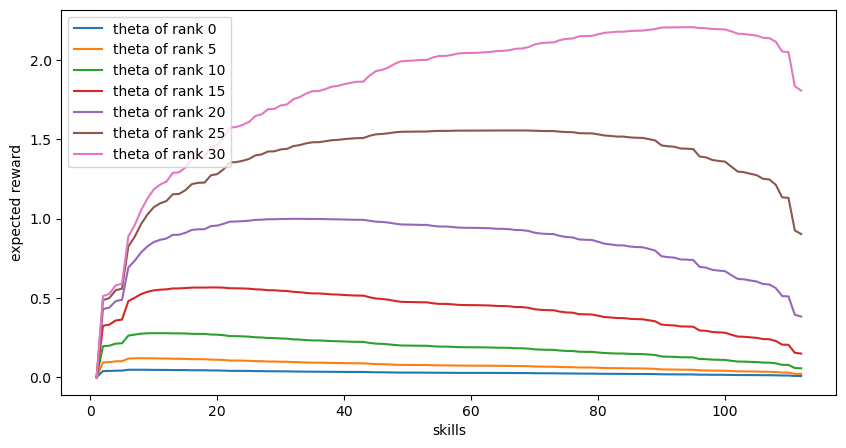

In [43]:
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,5))
for j in np.arange(0,50,5):
    

    expected_reward.iloc[j].plot(label='theta of rank '+str(j),xlabel='skills',ylabel='expected reward')
    plt.legend()

In [51]:
expected_reward

,1,2,3,4,5,6,7,8,9,10,...,103,104,105,106,107,108,109,110,111,112
-7.0,0.0,0.012861,0.01492,0.015723,0.016346,0.017461,0.017356,0.017045,0.016216,0.015536,...,0.001402,0.001326,0.001261,0.001257,0.001221,0.001137,0.001063,0.00079,0.000732,0.000475
-6.8,0.0,0.015601,0.018113,0.019094,0.019859,0.021234,0.021131,0.020759,0.019759,0.018935,...,0.001712,0.001619,0.001541,0.001536,0.001491,0.001389,0.001298,0.000965,0.000893,0.00058
-6.6,0.0,0.018895,0.02196,0.02316,0.024098,0.025798,0.02571,0.025266,0.024063,0.023067,...,0.002091,0.001977,0.001881,0.001876,0.001821,0.001696,0.001585,0.001179,0.001091,0.000708
-6.4,0.0,0.022846,0.026582,0.028051,0.029202,0.031307,0.031256,0.030728,0.029285,0.028085,...,0.002554,0.002415,0.002298,0.002291,0.002225,0.002071,0.001936,0.00144,0.001333,0.000865
-6.2,0.0,0.027564,0.032117,0.033915,0.035328,0.037941,0.037958,0.037337,0.035614,0.034172,...,0.003119,0.002949,0.002806,0.002798,0.002717,0.00253,0.002364,0.001758,0.001628,0.001056
-6.0,0.0,0.033173,0.038717,0.040918,0.042654,0.045904,0.046042,0.045316,0.04327,0.041542,...,0.003809,0.003602,0.003427,0.003417,0.003318,0.003089,0.002887,0.002147,0.001988,0.00129
-5.8,0.0,0.039805,0.046549,0.049242,0.051377,0.055429,0.055766,0.054927,0.052512,0.050452,...,0.004652,0.004399,0.004186,0.004172,0.004052,0.003773,0.003526,0.002623,0.002428,0.001575
-5.6,0.0,0.047595,0.055789,0.059084,0.061709,0.066772,0.067424,0.066467,0.063641,0.061198,...,0.005681,0.005371,0.005111,0.005095,0.004948,0.004607,0.004306,0.003203,0.002965,0.001924
-5.4,0.0,0.056677,0.066616,0.070643,0.073872,0.080211,0.081346,0.080277,0.077002,0.074125,...,0.006937,0.006559,0.006242,0.006222,0.006043,0.005626,0.005259,0.003912,0.003621,0.00235
-5.2,0.0,0.06717,0.079199,0.084116,0.088087,0.096037,0.097898,0.096732,0.092985,0.089624,...,0.00847,0.008009,0.007622,0.007598,0.007379,0.006871,0.006422,0.004777,0.004423,0.00287


outlook shows the difference in the distribution of the reward between fake_dic_panda and fake_dic_panda_real

In [64]:
outlook={}

for j in dt.user.unique():
    
    outlook['user_'+str(j)]=pd.concat([fake_dic_panda['user_'+str(j)].groupby('action_'+str(j))['reward_'+str(j)].describe()[['count','mean']],
                                       fake_dic_panda_real['user_'+str(j)].groupby('action_'+str(j))['reward_'+str(j)].describe()['mean'].rename('real_mean'),
                                       fake_dic_panda_theta['user_'+str(j)].groupby('action_'+str(j))['reward_'+str(j)].describe()['mean'].rename('mean_with_theta')
                                      ],axis=1)




In [65]:
import pickle 

with open('outlook.pkl', 'wb') as f:
    pickle.dump(outlook, f)

In [66]:
# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LinearRegression

In [44]:
import pickle

the steps consists in making our dataset usable for the open bandit pipeline


In [45]:
bdf_feedback_train={}
bdf_feedback_train['n_rounds']=186666
bdf_feedback_train['n_actions']=112
bdf_feedback_train['context']=bandit_dbf_real_train.theta.values.reshape(186666,1)
bdf_feedback_train['action_context']=np.eye(112)
bdf_feedback_train['action']=bandit_dbf_real_train.action.values.astype(int)-1
bdf_feedback_train['position']=None
bdf_feedback_train['reward']=bandit_dbf_real_train.reward.values
bdf_feedback_train['expected_reward']=expected_reward_real.loc[bandit_dbf_real_train.theta.values].values
bdf_feedback_train['pi_b']=empire_proba_real.loc[bandit_dbf_real_train.theta].values.reshape(186666,112,1)
bdf_feedback_train['pscore']=bdf_feedback_train['pi_b'][range(186666),bandit_dbf_real_train.action.values.astype(int)-1].reshape(186666,)



In [46]:
bdf_feedback_test={}
bdf_feedback_test['n_rounds']=91941
bdf_feedback_test['n_actions']=112
bdf_feedback_test['context']=bandit_dbf_real_test.theta.values.reshape(91941,1)
bdf_feedback_test['action_context']=np.eye(112)
bdf_feedback_test['action']=bandit_dbf_real_test.action.values.astype(int)-1
bdf_feedback_test['position']=None
bdf_feedback_test['reward']=bandit_dbf_real_test.reward.values
bdf_feedback_test['expected_reward']=expected_reward_real.loc[bandit_dbf_real_test.theta.values].values
bdf_feedback_test['pi_b']=empire_proba_real.loc[bandit_dbf_real_test.theta].values.reshape(91941,112,1)
bdf_feedback_test['pscore']=bdf_feedback_test['pi_b'][range(91941),bandit_dbf_real_test.action.values.astype(int)-1].reshape(91941,)


this step is to save as pkl file all the important data

In [47]:
import pickle 

with open('saved_bdf_train.pkl', 'wb') as f:
    pickle.dump(bdf_feedback_train, f)

In [48]:


with open('saved_bdf_test.pkl', 'wb') as f:
    pickle.dump(bdf_feedback_test, f)

In [49]:
with open('saved_fake_dic_panda.pkl', 'wb') as f:
    pickle.dump(fake_dic_panda, f)

In [50]:

with open('theta.pkl', 'wb') as f:
    pickle.dump(theta, f)

In [51]:
with open('diffik.pkl', 'wb') as f:
    pickle.dump(diffik, f)

In [52]:
with open('fiffik.pkl', 'wb') as f:
    pickle.dump(fiffik, f)

In [53]:
with open('empire_proba.pkl', 'wb') as f:
    pickle.dump(empire_proba, f)

In [54]:
with open('empire_proba_real.pkl', 'wb') as f:
    pickle.dump(empire_proba_real, f)

In [55]:
with open('empire_proba_real_train.pkl', 'wb') as f:
    pickle.dump(empire_proba_real_train, f)

In [56]:
with open('expected_reward.pkl', 'wb') as f:
    pickle.dump(expected_reward, f)